In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
import jax.scipy as jsp
from minigp.gp import *
from minigp.kernel import DeepKernelParameters, DeepKernel
from minigp.utils import *

In [2]:
def warp(x: jnp.ndarray) -> jnp.ndarray:
    """Warping function that maps [0, 24pi] to [0, 12pi], with non-linear squeezing."""
    # Define boundaries
    segment1 = 2 * jnp.pi
    segment2 = 10 * jnp.pi
    max_x = 12 * jnp.pi

    # Define corresponding warped boundaries
    warped_segment1 = 16 * jnp.pi
    warped_segment2 = 18 * jnp.pi
    max_warped = 34 * jnp.pi

    # Apply piecewise transformation
    warped_x = jnp.where(x <= segment1,
                         x * (warped_segment1 / segment1),  # Squeeze the first segment
                         jnp.where(x <= segment2,
                                   (x - segment1) * ((warped_segment2 - warped_segment1) / (segment2 - segment1)) + warped_segment1,  # Middle segment mostly unchanged
                                   (x - segment2) * ((max_warped - warped_segment2) / (max_x - segment2)) + warped_segment2  # Squeeze the last segment
                         ))
    return warped_x

def warped_sine(x: jnp.ndarray) -> jnp.ndarray:
    """Compute sine of the warped input."""
    warped_x = warp(x)
    return jnp.sin(warped_x)


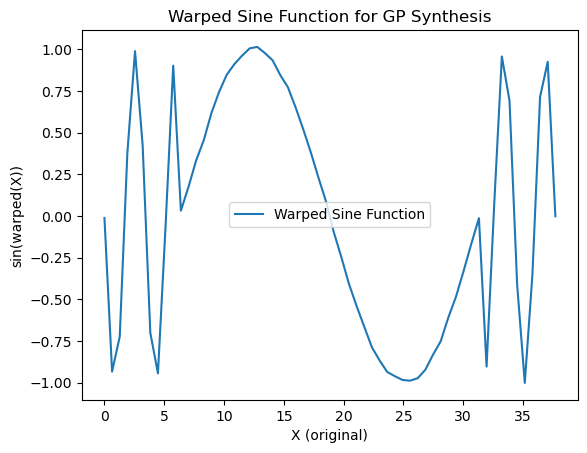

In [3]:
X_train = jnp.linspace(0, 12 * jnp.pi, 60).reshape(-1, 1)
y_train = warped_sine(X_train.flatten()) + 0.01 * random.normal(jax.random.PRNGKey(0), (60,))

X_np = np.array(X_train)
y_np = np.array(y_train)

# Plot the warped sine function
plt.plot(X_np, y_np, label="Warped Sine Function")
plt.title("Warped Sine Function for GP Synthesis")
plt.xlabel("X (original)")
plt.ylabel("sin(warped(X))")
plt.legend()
plt.show()

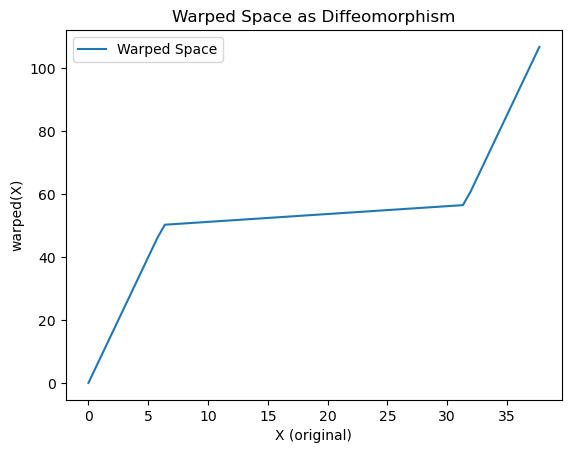

In [4]:
plt.plot(X_np, np.array(warp(X_train)), label="Warped Space")
plt.title("Warped Space as Diffeomorphism")
plt.xlabel("X (original)")
plt.ylabel("warped(X)")
plt.legend()
plt.show()

In [5]:
block = [1,15,15]
layer_dims = block * 10 + [1]

key = jax.random.PRNGKey(0)

net = ResNetNN(layer_dims, key)
kernel = DeepKernel(net_fn=net, layer_dims=layer_dims)
kernel_params = kernel.init_params(key)

gp = GaussianProcess()
state, gp_params = gp.init_state_with_params(kernel, kernel_params, X_train, y_train)

In [6]:
optimized_kernel_params, optimized_gp_params = optimize_mle_nn(gp, state, kernel_params, gp_params, num_iters= 700, learning_rate = 0.02)
state, gp_params = gp.fit(state, optimized_kernel_params, optimized_gp_params)

Iteration 50, Loss: 53.5860
Iteration 100, Loss: 46.7143
Iteration 150, Loss: 46.1783
Iteration 200, Loss: 44.3468
Iteration 250, Loss: 44.3466
Iteration 300, Loss: 42.8300
Iteration 350, Loss: 42.8735
Iteration 400, Loss: 42.6405
Iteration 450, Loss: 42.8179
Iteration 500, Loss: 42.5861
Iteration 550, Loss: 43.0264
Iteration 600, Loss: 42.2999
Iteration 650, Loss: 41.2693
Iteration 700, Loss: 41.4340


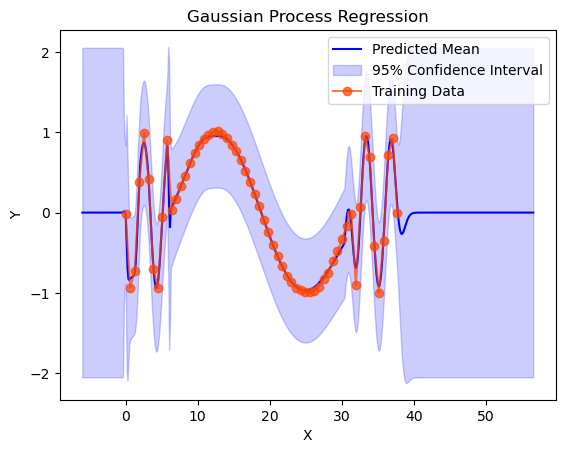

In [7]:
X_test = jnp.linspace(-6, 18 * jnp.pi, 500).reshape(-1, 1)
y_true = warped_sine(X_test.flatten())
mu_s, cov_s = gp.predict(state, optimized_kernel_params, optimized_gp_params, X_test)
std_s = jnp.sqrt(cov_s)

plot_process(X_train, y_train, X_test, mu_s, std_s)

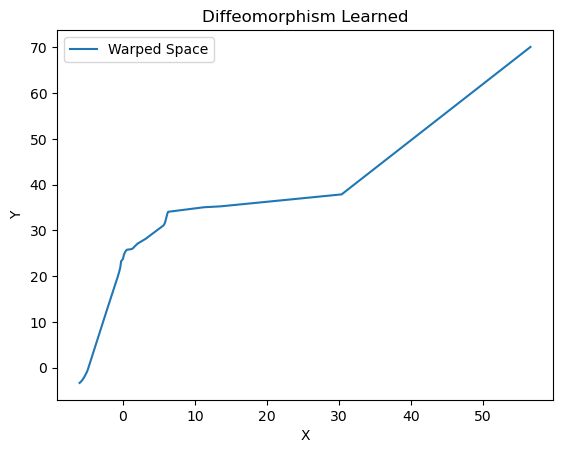

In [8]:
plot_diffeomorphism_1D(X_test, kernel, optimized_kernel_params)

In [9]:
print(optimized_kernel_params)

DeepKernelParameters(sigma=Array(0.877, dtype=float32), nn_params={'W1': Array([[ 0.132,  0.235, -0.161, -0.094, -0.103, -0.113, -0.069,  0.161,
        -0.277, -0.116,  0.292,  0.363, -0.095, -0.232, -0.377]],      dtype=float32), 'W10': Array([[-0.219,  0.109,  0.283, -0.127,  0.173, -0.404, -0.059, -0.047,
         0.008,  0.057,  0.071, -0.082,  0.215,  0.194, -0.101]],      dtype=float32), 'W11': Array([[-0.307, -0.3  ,  0.152, -0.091,  0.455, -0.063, -0.056, -0.319,
        -0.042,  0.095,  0.175,  0.1  , -0.415, -0.009,  0.091],
       [ 0.236,  0.15 , -0.191,  0.162, -0.151,  0.011,  0.137,  0.263,
         0.14 , -0.172, -0.144, -0.048,  0.524,  0.039,  0.01 ],
       [ 0.252, -0.263,  0.245, -0.317, -0.172, -0.329, -0.287,  0.292,
        -0.289,  0.055,  0.143,  0.069,  0.34 , -0.505,  0.049],
       [-0.268, -0.151,  0.09 ,  0.062,  0.142, -0.142,  0.033, -0.365,
        -0.082,  0.023,  0.219,  0.117, -0.3  , -0.149,  0.087],
       [ 0.306,  0.219, -0.218,  0.157, -0.046,